In [88]:
import pandas as pd
import nltk
import string
import spacy
from nltk.corpus import stopwords
from textblob import TextBlob
import shap
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier  # Puede ser cualquier clasificador
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [79]:


# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

# Cargar dataset
# Aquí asumiré que tu dataset está en un archivo CSV llamado 'comments_dataset.csv' y que la columna de comentarios se llama 'comment'
df_original = pd.read_csv('train.csv')
df_original = df_original.drop(columns=['textID', 'text', 'Time of Tweet','Age of User','Country','Population -2020','Land Area (Km)','Density (P/Km)'])
df_original = df_original[df_original['selected_text'].apply(lambda x: isinstance(x, str))]

#Sample del 50% de los datos
df_original = df_original.sample(frac=0.05, random_state=1)

df_base = df_original.copy()




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [80]:
df_base.head()

,selected_text,sentiment
1638,smH daTs whacK,neutral
14748,"oh dear, thats not good - I hope you get throu...",neutral
5456,stuvk with the wee stpid thing fo,negative
19241,uni email is helpful..,positive
4067,", Just read an article that buying IP`s doesn`...",neutral


In [81]:
def preprocess_text(text):
    # 0. Eliminación de números
    #text = re.sub(r'\b\d+(\.\d+)?\b', '', text)
    
    # 1. Conversión a minúsculas
    text = text.lower()
    
    # 2. Eliminación de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Eliminación de stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # 4. Lematización
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    
    # 5. Corrección ortográfica
    text = str(TextBlob(text).correct())
    
    return text

# Aplicar preprocesamiento
df_base['processed_text'] = df_base['selected_text'].apply(preprocess_text)


In [85]:


# Vectorización de texto
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_base['processed_text'])
y = df_base['sentiment']

# sentiments = df_base['sentiment'].unique()
# # Inicializa el codificador
# label_encoder = LabelEncoder()
# # Convierte las etiquetas de texto en números
# y = label_encoder.fit_transform(sentiments)


# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.75


 98%|===================| 809/825 [00:50<00:00]        C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


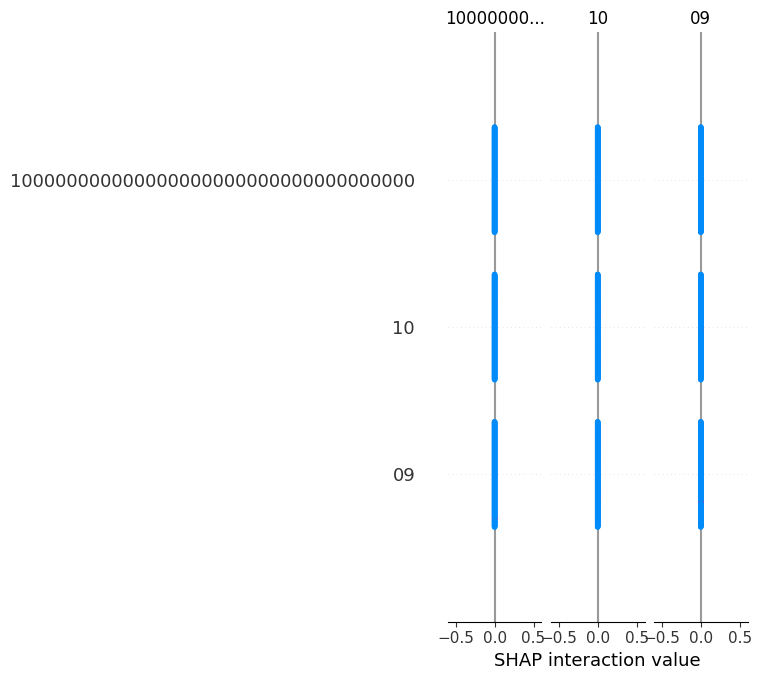

In [93]:
# Convertir la matriz dispersa a una densa
X_train_dense = X_train.toarray()

# Crear el explicador de SHAP
explainer = shap.Explainer(model, X_train_dense)

# Obtener los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test.toarray())  # Asegúrate de convertir X_test también si es una matriz dispersa

# Visualización de las explicaciones
shap.summary_plot(shap_values, X_test.toarray(), feature_names=vectorizer.get_feature_names_out())